# 06 — Error-Drift Correlation Analysis

**Mục tiêu:**
- **(A) Flip Matrix + Error Type Analysis**: Phân loại chi tiết 38% flip rate
  - Polarity reversal (negative↔positive)
  - Neutralization (sentiment → neutral)
  - Error patterns by language
  
- **(B) Correlation: CTAM Drift ↔ Prediction Errors**: 
  - Do high CTAM drift samples make more errors?
  - Does explanation consistency (overlap) predict correctness?
  - Statistical test: t-test, correlation coefficient

**Lý do quan trọng cho paper:**
- Kết nối 2 findings chính: "robustness fail" vs "explanation stable"
- Trả lời câu hỏi reviewer: "If explanations consistent, why predictions fail?"
- Biến quan sát thành kết luận có kiểm chứng (quantitative evidence)

**Effort:** Low-Medium (CPU only, analyze existing CSV files)
**Contribution Impact:** Very High (connects main findings with statistical evidence)

In [1]:
# Imports
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

print('Pandas:', pd.__version__)
print('Seaborn:', sns.__version__)

Pandas: 2.3.3
Seaborn: 0.13.2


## 1) Config

In [2]:
# Paths
PREDICTION_FILE = Path('translation_eval/test_with_predictions.csv')
XAI_FILE = Path('xai_results/xai_full_results.csv')
OUTPUT_DIR = Path('error_drift_analysis')
OUTPUT_DIR.mkdir(exist_ok=True)

# Label mapping (from 03_train_model.ipynb)
LABEL_MAP = {
    0: 'negative',
    1: 'neutral',
    2: 'positive'
}

print(f'Output directory: {OUTPUT_DIR.resolve()}')

Output directory: C:\Paper\Twitter proejct\Twitter Sentiment Analysis Dataset\Twitter Sentiment Analysis Dataset\error_drift_analysis


## Part A: Flip Matrix + Error Type Analysis

### A1) Load prediction data

In [3]:
df_pred = pd.read_csv(PREDICTION_FILE)
print('Prediction data shape:', df_pred.shape)
print('\nColumns:', df_pred.columns.tolist())
print('\nFirst few rows:')
display(df_pred.head(3))

Prediction data shape: (1998, 8)

Columns: ['cleaned_text', 'sentiment', 'text_es', 'text_fr', 'label_id', 'pred_en', 'pred_es', 'pred_fr']

First few rows:


,cleaned_text,sentiment,text_es,text_fr,label_id,pred_en,pred_es,pred_fr
0,Phishing breached our database. Reality kitche...,negative,Phishing rompió nuestra base de datos la cocin...,L'hameçonnage a violé notre base de données.,0,0,0,0
1,Theory I song down concern upon air grow cause...,negative,La teoría de la preocupación por el aire crece...,La théorie que je chante s'inquiète de la croi...,0,0,1,1
2,Away apply budget believe cold half answer the...,negative,Lejos de aplicar el presupuesto creen que la m...,Loin d'appliquer le budget croire froide moiti...,0,0,1,0


### A2) Label flip analysis: EN→ES

In [4]:
# Map predictions to label names
df_pred['pred_en_label'] = df_pred['pred_en'].map(LABEL_MAP)
df_pred['pred_es_label'] = df_pred['pred_es'].map(LABEL_MAP)
df_pred['pred_fr_label'] = df_pred['pred_fr'].map(LABEL_MAP)
df_pred['true_label'] = df_pred['label_id'].map(LABEL_MAP)

# Flip indicator
df_pred['flipped_es'] = (df_pred['pred_en'] != df_pred['pred_es'])
df_pred['flipped_fr'] = (df_pred['pred_en'] != df_pred['pred_fr'])

print('Flip rates:')
print(f"  EN→ES: {df_pred['flipped_es'].mean():.2%}")
print(f"  EN→FR: {df_pred['flipped_fr'].mean():.2%}")

Flip rates:
  EN→ES: 38.69%
  EN→FR: 38.29%


### A3) Confusion matrix: EN pred → ES pred

In [5]:
from sklearn.metrics import confusion_matrix

# Confusion matrix: EN pred vs ES pred
cm_es = confusion_matrix(df_pred['pred_en'], df_pred['pred_es'], labels=[0, 1, 2])
cm_es_df = pd.DataFrame(cm_es, 
                        index=['EN: neg', 'EN: neu', 'EN: pos'],
                        columns=['ES: neg', 'ES: neu', 'ES: pos'])

print('\nConfusion Matrix: EN pred → ES pred')
print('(Rows: EN prediction, Columns: ES prediction)')
display(cm_es_df)

# Normalize to percentages
cm_es_pct = cm_es / cm_es.sum(axis=1, keepdims=True) * 100
cm_es_pct_df = pd.DataFrame(cm_es_pct, 
                            index=['EN: neg', 'EN: neu', 'EN: pos'],
                            columns=['ES: neg', 'ES: neu', 'ES: pos'])

print('\nConfusion Matrix (Percentages):')
display(cm_es_pct_df.round(1))


Confusion Matrix: EN pred → ES pred
(Rows: EN prediction, Columns: ES prediction)


,ES: neg,ES: neu,ES: pos
EN: neg,260,409,13
EN: neu,21,569,32
EN: pos,36,262,396



Confusion Matrix (Percentages):


,ES: neg,ES: neu,ES: pos
EN: neg,38.1,60.0,1.9
EN: neu,3.4,91.5,5.1
EN: pos,5.2,37.8,57.1


In [6]:
# Same for FR
cm_fr = confusion_matrix(df_pred['pred_en'], df_pred['pred_fr'], labels=[0, 1, 2])
cm_fr_df = pd.DataFrame(cm_fr, 
                        index=['EN: neg', 'EN: neu', 'EN: pos'],
                        columns=['FR: neg', 'FR: neu', 'FR: pos'])

print('\nConfusion Matrix: EN pred → FR pred')
display(cm_fr_df)

cm_fr_pct = cm_fr / cm_fr.sum(axis=1, keepdims=True) * 100
cm_fr_pct_df = pd.DataFrame(cm_fr_pct, 
                            index=['EN: neg', 'EN: neu', 'EN: pos'],
                            columns=['FR: neg', 'FR: neu', 'FR: pos'])

print('\nConfusion Matrix (Percentages):')
display(cm_fr_pct_df.round(1))


Confusion Matrix: EN pred → FR pred


,FR: neg,FR: neu,FR: pos
EN: neg,261,402,19
EN: neu,21,569,32
EN: pos,9,282,403



Confusion Matrix (Percentages):


,FR: neg,FR: neu,FR: pos
EN: neg,38.3,58.9,2.8
EN: neu,3.4,91.5,5.1
EN: pos,1.3,40.6,58.1


### A4) Error type classification

In [7]:
def classify_flip_type(pred_en, pred_target):
    """
    Classify flip into categories:
    - 'no_flip': predictions match
    - 'polarity_reversal': negative↔positive (skip neutral)
    - 'neutralization': non-neutral → neutral
    - 'de_neutralization': neutral → non-neutral
    - 'other': other flip patterns
    """
    if pred_en == pred_target:
        return 'no_flip'
    
    # Polarity reversal: 0↔2 (negative↔positive)
    if (pred_en == 0 and pred_target == 2) or (pred_en == 2 and pred_target == 0):
        return 'polarity_reversal'
    
    # Neutralization: non-neutral → neutral
    if pred_en in [0, 2] and pred_target == 1:
        return 'neutralization'
    
    # De-neutralization: neutral → non-neutral
    if pred_en == 1 and pred_target in [0, 2]:
        return 'de_neutralization'
    
    return 'other'

# Apply classification
df_pred['flip_type_es'] = df_pred.apply(
    lambda row: classify_flip_type(row['pred_en'], row['pred_es']), axis=1
)
df_pred['flip_type_fr'] = df_pred.apply(
    lambda row: classify_flip_type(row['pred_en'], row['pred_fr']), axis=1
)

print('\nFlip Type Distribution (EN→ES):')
flip_es_counts = df_pred['flip_type_es'].value_counts()
flip_es_pct = df_pred['flip_type_es'].value_counts(normalize=True) * 100
flip_es_summary = pd.DataFrame({
    'Count': flip_es_counts,
    'Percentage': flip_es_pct.round(2)
})
display(flip_es_summary)

print('\nFlip Type Distribution (EN→FR):')
flip_fr_counts = df_pred['flip_type_fr'].value_counts()
flip_fr_pct = df_pred['flip_type_fr'].value_counts(normalize=True) * 100
flip_fr_summary = pd.DataFrame({
    'Count': flip_fr_counts,
    'Percentage': flip_fr_pct.round(2)
})
display(flip_fr_summary)


Flip Type Distribution (EN→ES):


,Count,Percentage
flip_type_es,,
no_flip,1225,61.31
neutralization,671,33.58
de_neutralization,53,2.65
polarity_reversal,49,2.45



Flip Type Distribution (EN→FR):


,Count,Percentage
flip_type_fr,,
no_flip,1233,61.71
neutralization,684,34.23
de_neutralization,53,2.65
polarity_reversal,28,1.40


### A5) Visualize flip types

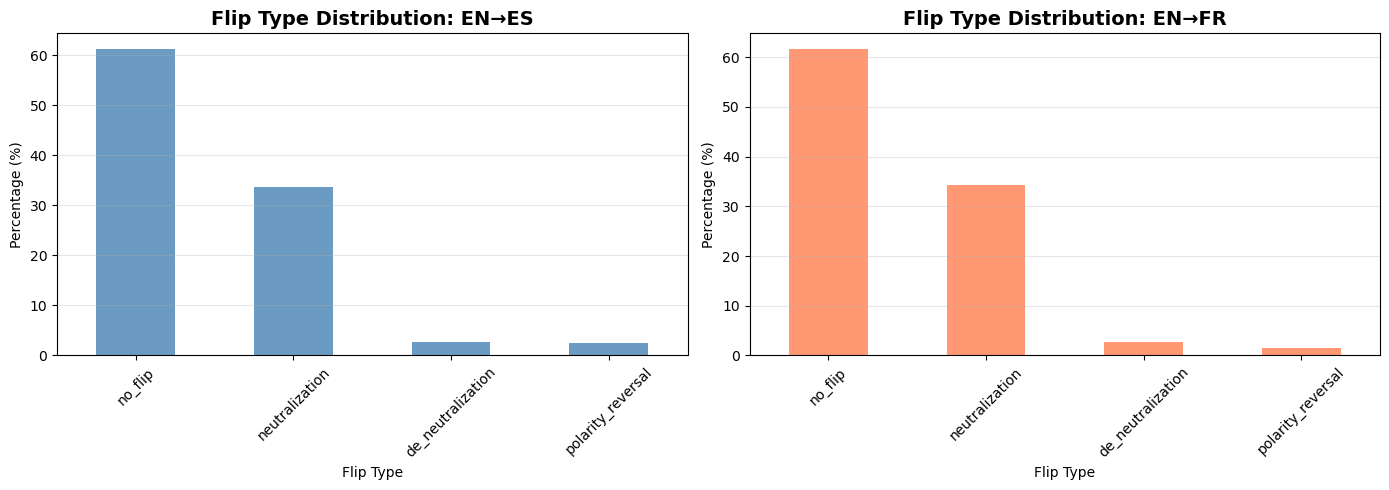


✅ Flip type visualization saved


In [8]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# EN→ES
flip_es_pct.plot(kind='bar', ax=axes[0], color='steelblue', alpha=0.8)
axes[0].set_title('Flip Type Distribution: EN→ES', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Flip Type')
axes[0].set_ylabel('Percentage (%)')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(alpha=0.3, axis='y')

# EN→FR
flip_fr_pct.plot(kind='bar', ax=axes[1], color='coral', alpha=0.8)
axes[1].set_title('Flip Type Distribution: EN→FR', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Flip Type')
axes[1].set_ylabel('Percentage (%)')
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'flip_type_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print(f'\n✅ Flip type visualization saved')

### A6) Save flip analysis results

In [9]:
# Combine ES and FR flip summaries
flip_summary = pd.DataFrame({
    'flip_type': flip_es_summary.index,
    'count_es': flip_es_summary['Count'].values,
    'pct_es': flip_es_summary['Percentage'].values,
    'count_fr': flip_fr_summary['Count'].values,
    'pct_fr': flip_fr_summary['Percentage'].values
})

flip_summary.to_csv(OUTPUT_DIR / 'flip_type_summary.csv', index=False)
print('\n✅ Flip type summary saved to flip_type_summary.csv')
display(flip_summary)


✅ Flip type summary saved to flip_type_summary.csv


,flip_type,count_es,pct_es,count_fr,pct_fr
0,no_flip,1225,61.31,1233,61.71
1,neutralization,671,33.58,684,34.23
2,de_neutralization,53,2.65,53,2.65
3,polarity_reversal,49,2.45,28,1.40


---
## Part B: Correlation Analysis (CTAM Drift ↔ Prediction Errors)

### B1) Load XAI results

In [10]:
df_xai = pd.read_csv(XAI_FILE)
print('XAI data shape:', df_xai.shape)
print('\nColumns:', df_xai.columns.tolist())
print('\nFirst few rows:')
display(df_xai.head(3))

XAI data shape: (198, 14)

Columns: ['index', 'label_true', 'pred_en', 'pred_es', 'pred_fr', 'ctam_en', 'ctam_es', 'ctam_fr', 'ctam_drift_es', 'ctam_drift_fr', 'overlap_jaccard_es', 'overlap_jaccard_fr', 'overlap_count_es', 'overlap_count_fr']

First few rows:


,index,label_true,pred_en,pred_es,pred_fr,ctam_en,ctam_es,ctam_fr,ctam_drift_es,ctam_drift_fr,overlap_jaccard_es,overlap_jaccard_fr,overlap_count_es,overlap_count_fr
0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0,0
1,1,0,0,1,0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0,0
2,2,0,0,1,0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0,0


### B2) Add correctness indicators

In [11]:
# Prediction correctness
df_xai['correct_en'] = (df_xai['pred_en'] == df_xai['label_true'])
df_xai['correct_es'] = (df_xai['pred_es'] == df_xai['label_true'])
df_xai['correct_fr'] = (df_xai['pred_fr'] == df_xai['label_true'])

# Flip indicators
df_xai['flipped_es'] = (df_xai['pred_en'] != df_xai['pred_es'])
df_xai['flipped_fr'] = (df_xai['pred_en'] != df_xai['pred_fr'])

print('\nCorrectness rates:')
print(f"  EN: {df_xai['correct_en'].mean():.2%}")
print(f"  ES: {df_xai['correct_es'].mean():.2%}")
print(f"  FR: {df_xai['correct_fr'].mean():.2%}")

print('\nFlip rates (in XAI sample):')
print(f"  EN→ES: {df_xai['flipped_es'].mean():.2%}")
print(f"  EN→FR: {df_xai['flipped_fr'].mean():.2%}")


Correctness rates:
  EN: 94.95%
  ES: 60.10%
  FR: 62.63%

Flip rates (in XAI sample):
  EN→ES: 39.90%
  EN→FR: 37.37%


### B3) Correlation: CTAM drift vs correctness (ES)

In [12]:
# Compare CTAM drift between correct and wrong predictions
ctam_drift_correct_es = df_xai[df_xai['correct_es']]['ctam_drift_es']
ctam_drift_wrong_es = df_xai[~df_xai['correct_es']]['ctam_drift_es']

print('\n=== CTAM Drift vs Correctness (ES) ===')
print(f'\nCorrect ES predictions (n={len(ctam_drift_correct_es)}):')
print(f'  Mean CTAM drift: {ctam_drift_correct_es.mean():.4f}')
print(f'  Std CTAM drift: {ctam_drift_correct_es.std():.4f}')

print(f'\nWrong ES predictions (n={len(ctam_drift_wrong_es)}):')
print(f'  Mean CTAM drift: {ctam_drift_wrong_es.mean():.4f}')
print(f'  Std CTAM drift: {ctam_drift_wrong_es.std():.4f}')

# T-test
t_stat, p_value = stats.ttest_ind(ctam_drift_correct_es, ctam_drift_wrong_es)
print(f'\nT-test: t={t_stat:.3f}, p={p_value:.4f}')
if p_value < 0.05:
    print('=> Statistically significant difference (p < 0.05)')
else:
    print('=> No statistically significant difference (p >= 0.05)')


=== CTAM Drift vs Correctness (ES) ===

Correct ES predictions (n=119):
  Mean CTAM drift: -0.0062
  Std CTAM drift: 0.0697

Wrong ES predictions (n=79):
  Mean CTAM drift: -0.0022
  Std CTAM drift: 0.0428

T-test: t=-0.465, p=0.6427
=> No statistically significant difference (p >= 0.05)


In [13]:
# Same for FR
ctam_drift_correct_fr = df_xai[df_xai['correct_fr']]['ctam_drift_fr']
ctam_drift_wrong_fr = df_xai[~df_xai['correct_fr']]['ctam_drift_fr']

print('\n=== CTAM Drift vs Correctness (FR) ===')
print(f'\nCorrect FR predictions (n={len(ctam_drift_correct_fr)}):')
print(f'  Mean CTAM drift: {ctam_drift_correct_fr.mean():.4f}')
print(f'  Std CTAM drift: {ctam_drift_correct_fr.std():.4f}')

print(f'\nWrong FR predictions (n={len(ctam_drift_wrong_fr)}):')
print(f'  Mean CTAM drift: {ctam_drift_wrong_fr.mean():.4f}')
print(f'  Std CTAM drift: {ctam_drift_wrong_fr.std():.4f}')

t_stat_fr, p_value_fr = stats.ttest_ind(ctam_drift_correct_fr, ctam_drift_wrong_fr)
print(f'\nT-test: t={t_stat_fr:.3f}, p={p_value_fr:.4f}')
if p_value_fr < 0.05:
    print('=> Statistically significant difference (p < 0.05)')
else:
    print('=> No statistically significant difference (p >= 0.05)')


=== CTAM Drift vs Correctness (FR) ===

Correct FR predictions (n=124):
  Mean CTAM drift: -0.0127
  Std CTAM drift: 0.0599

Wrong FR predictions (n=74):
  Mean CTAM drift: -0.0002
  Std CTAM drift: 0.0444

T-test: t=-1.558, p=0.1209
=> No statistically significant difference (p >= 0.05)


### B4) Correlation: Overlap vs correctness

In [14]:
# Compare overlap between correct and wrong predictions
overlap_correct_es = df_xai[df_xai['correct_es']]['overlap_jaccard_es']
overlap_wrong_es = df_xai[~df_xai['correct_es']]['overlap_jaccard_es']

print('\n=== Overlap vs Correctness (ES) ===')
print(f'\nCorrect ES predictions:')
print(f'  Mean Jaccard overlap: {overlap_correct_es.mean():.4f}')
print(f'  Std Jaccard overlap: {overlap_correct_es.std():.4f}')

print(f'\nWrong ES predictions:')
print(f'  Mean Jaccard overlap: {overlap_wrong_es.mean():.4f}')
print(f'  Std Jaccard overlap: {overlap_wrong_es.std():.4f}')

t_stat_overlap, p_value_overlap = stats.ttest_ind(overlap_correct_es, overlap_wrong_es)
print(f'\nT-test: t={t_stat_overlap:.3f}, p={p_value_overlap:.4f}')
if p_value_overlap < 0.05:
    print('=> Statistically significant difference (p < 0.05)')
else:
    print('=> No statistically significant difference (p >= 0.05)')


=== Overlap vs Correctness (ES) ===

Correct ES predictions:
  Mean Jaccard overlap: 0.8504
  Std Jaccard overlap: 0.3563

Wrong ES predictions:
  Mean Jaccard overlap: 0.8776
  Std Jaccard overlap: 0.3255

T-test: t=-0.545, p=0.5866
=> No statistically significant difference (p >= 0.05)


In [15]:
# Same for FR
overlap_correct_fr = df_xai[df_xai['correct_fr']]['overlap_jaccard_fr']
overlap_wrong_fr = df_xai[~df_xai['correct_fr']]['overlap_jaccard_fr']

print('\n=== Overlap vs Correctness (FR) ===')
print(f'\nCorrect FR predictions:')
print(f'  Mean Jaccard overlap: {overlap_correct_fr.mean():.4f}')
print(f'  Std Jaccard overlap: {overlap_correct_fr.std():.4f}')

print(f'\nWrong FR predictions:')
print(f'  Mean Jaccard overlap: {overlap_wrong_fr.mean():.4f}')
print(f'  Std Jaccard overlap: {overlap_wrong_fr.std():.4f}')

t_stat_overlap_fr, p_value_overlap_fr = stats.ttest_ind(overlap_correct_fr, overlap_wrong_fr)
print(f'\nT-test: t={t_stat_overlap_fr:.3f}, p={p_value_overlap_fr:.4f}')
if p_value_overlap_fr < 0.05:
    print('=> Statistically significant difference (p < 0.05)')
else:
    print('=> No statistically significant difference (p >= 0.05)')


=== Overlap vs Correctness (FR) ===

Correct FR predictions:
  Mean Jaccard overlap: 0.8137
  Std Jaccard overlap: 0.3791

Wrong FR predictions:
  Mean Jaccard overlap: 0.9392
  Std Jaccard overlap: 0.2334

T-test: t=-2.570, p=0.0109
=> Statistically significant difference (p < 0.05)


### B5) Visualizations: Boxplots

C:\Users\Nguyen Ngo\AppData\Local\Temp\ipykernel_9728\2193429108.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='correct_es_label', y='ctam_drift_es', data=df_xai, ax=axes[0, 0], palette='Set2')
C:\Users\Nguyen Ngo\AppData\Local\Temp\ipykernel_9728\2193429108.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='correct_fr_label', y='ctam_drift_fr', data=df_xai, ax=axes[0, 1], palette='Set2')
C:\Users\Nguyen Ngo\AppData\Local\Temp\ipykernel_9728\2193429108.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='correct_es_label', y=

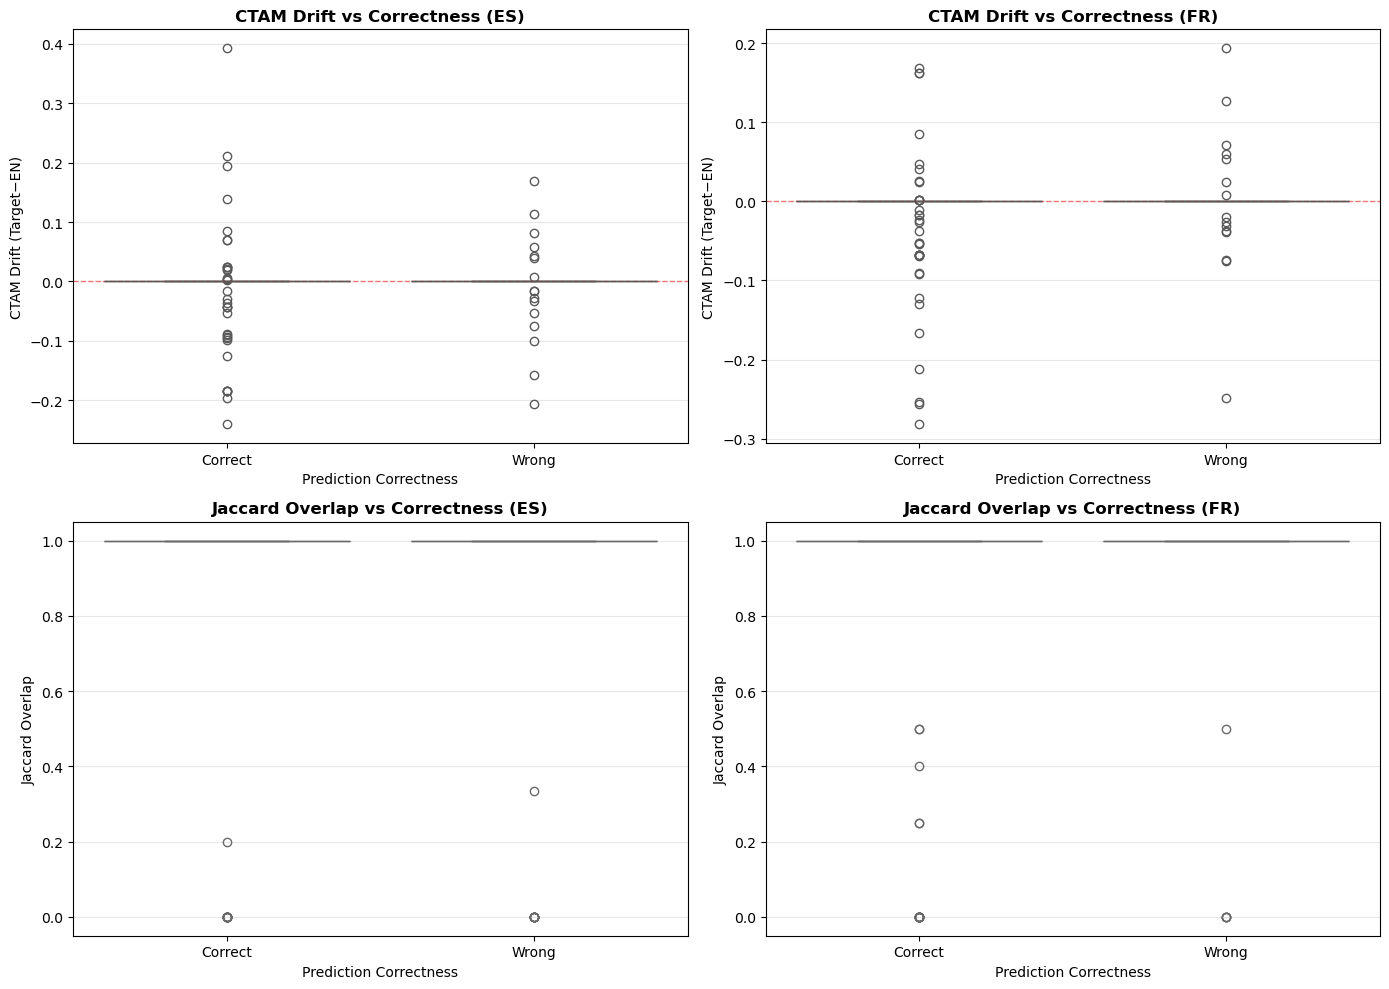


✅ Boxplot visualization saved


In [16]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Prepare data for boxplots
df_xai['correct_es_label'] = df_xai['correct_es'].map({True: 'Correct', False: 'Wrong'})
df_xai['correct_fr_label'] = df_xai['correct_fr'].map({True: 'Correct', False: 'Wrong'})

# CTAM drift vs correctness (ES)
sns.boxplot(x='correct_es_label', y='ctam_drift_es', data=df_xai, ax=axes[0, 0], palette='Set2')
axes[0, 0].set_title('CTAM Drift vs Correctness (ES)', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Prediction Correctness')
axes[0, 0].set_ylabel('CTAM Drift (Target−EN)')
axes[0, 0].axhline(0, color='red', linestyle='--', linewidth=1, alpha=0.5)
axes[0, 0].grid(alpha=0.3, axis='y')

# CTAM drift vs correctness (FR)
sns.boxplot(x='correct_fr_label', y='ctam_drift_fr', data=df_xai, ax=axes[0, 1], palette='Set2')
axes[0, 1].set_title('CTAM Drift vs Correctness (FR)', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Prediction Correctness')
axes[0, 1].set_ylabel('CTAM Drift (Target−EN)')
axes[0, 1].axhline(0, color='red', linestyle='--', linewidth=1, alpha=0.5)
axes[0, 1].grid(alpha=0.3, axis='y')

# Overlap vs correctness (ES)
sns.boxplot(x='correct_es_label', y='overlap_jaccard_es', data=df_xai, ax=axes[1, 0], palette='Set3')
axes[1, 0].set_title('Jaccard Overlap vs Correctness (ES)', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Prediction Correctness')
axes[1, 0].set_ylabel('Jaccard Overlap')
axes[1, 0].grid(alpha=0.3, axis='y')

# Overlap vs correctness (FR)
sns.boxplot(x='correct_fr_label', y='overlap_jaccard_fr', data=df_xai, ax=axes[1, 1], palette='Set3')
axes[1, 1].set_title('Jaccard Overlap vs Correctness (FR)', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Prediction Correctness')
axes[1, 1].set_ylabel('Jaccard Overlap')
axes[1, 1].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'drift_overlap_vs_correctness.png', dpi=150, bbox_inches='tight')
plt.show()

print('\n✅ Boxplot visualization saved')

### B6) Scatter plots: Drift vs Overlap (colored by correctness)

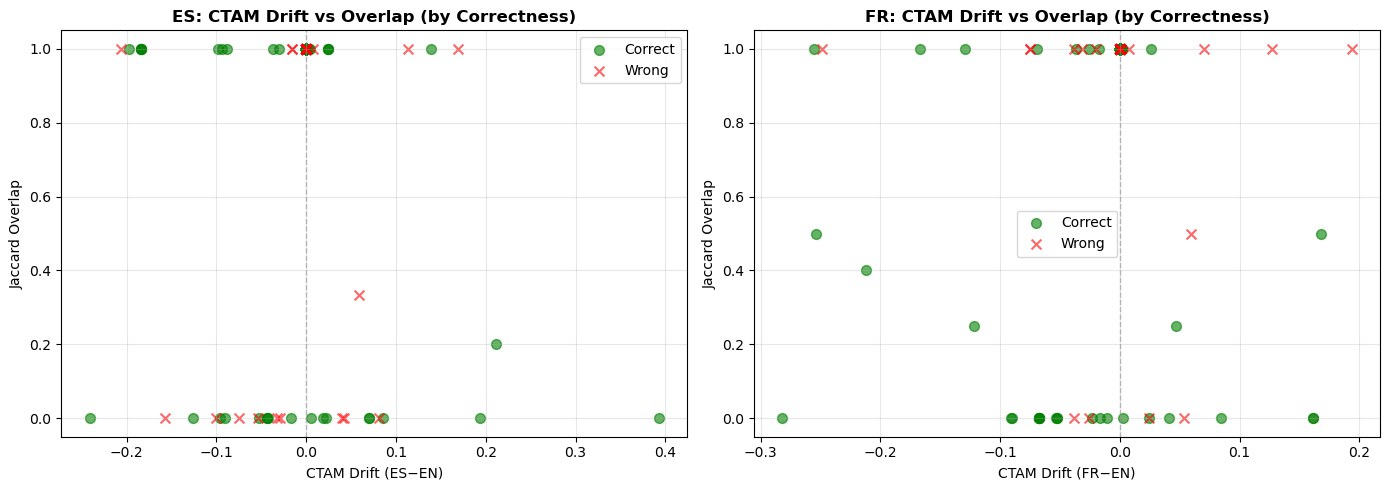


✅ Scatter plot saved


In [17]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ES: CTAM drift vs Overlap
correct_es = df_xai[df_xai['correct_es']]
wrong_es = df_xai[~df_xai['correct_es']]

axes[0].scatter(correct_es['ctam_drift_es'], correct_es['overlap_jaccard_es'], 
               alpha=0.6, s=50, label='Correct', color='green')
axes[0].scatter(wrong_es['ctam_drift_es'], wrong_es['overlap_jaccard_es'], 
               alpha=0.6, s=50, label='Wrong', color='red', marker='x')
axes[0].set_xlabel('CTAM Drift (ES−EN)')
axes[0].set_ylabel('Jaccard Overlap')
axes[0].set_title('ES: CTAM Drift vs Overlap (by Correctness)', fontsize=12, fontweight='bold')
axes[0].axvline(0, color='gray', linestyle='--', linewidth=1, alpha=0.5)
axes[0].legend()
axes[0].grid(alpha=0.3)

# FR: CTAM drift vs Overlap
correct_fr = df_xai[df_xai['correct_fr']]
wrong_fr = df_xai[~df_xai['correct_fr']]

axes[1].scatter(correct_fr['ctam_drift_fr'], correct_fr['overlap_jaccard_fr'], 
               alpha=0.6, s=50, label='Correct', color='green')
axes[1].scatter(wrong_fr['ctam_drift_fr'], wrong_fr['overlap_jaccard_fr'], 
               alpha=0.6, s=50, label='Wrong', color='red', marker='x')
axes[1].set_xlabel('CTAM Drift (FR−EN)')
axes[1].set_ylabel('Jaccard Overlap')
axes[1].set_title('FR: CTAM Drift vs Overlap (by Correctness)', fontsize=12, fontweight='bold')
axes[1].axvline(0, color='gray', linestyle='--', linewidth=1, alpha=0.5)
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'scatter_drift_vs_overlap.png', dpi=150, bbox_inches='tight')
plt.show()

print('\n✅ Scatter plot saved')

### B7) Correlation coefficients

In [18]:
# Pearson correlation: CTAM drift vs Overlap
corr_es, p_corr_es = stats.pearsonr(df_xai['ctam_drift_es'], df_xai['overlap_jaccard_es'])
corr_fr, p_corr_fr = stats.pearsonr(df_xai['ctam_drift_fr'], df_xai['overlap_jaccard_fr'])

print('\n=== Correlation: CTAM Drift vs Overlap ===')
print(f'ES: r={corr_es:.3f}, p={p_corr_es:.4f}')
print(f'FR: r={corr_fr:.3f}, p={p_corr_fr:.4f}')

# Point-biserial correlation: CTAM drift vs correctness (binary)
from scipy.stats import pointbiserialr

corr_ctam_correct_es, p_ctam_correct_es = pointbiserialr(df_xai['correct_es'], df_xai['ctam_drift_es'])
corr_ctam_correct_fr, p_ctam_correct_fr = pointbiserialr(df_xai['correct_fr'], df_xai['ctam_drift_fr'])

print('\n=== Correlation: CTAM Drift vs Correctness ===')
print(f'ES: r={corr_ctam_correct_es:.3f}, p={p_ctam_correct_es:.4f}')
print(f'FR: r={corr_ctam_correct_fr:.3f}, p={p_ctam_correct_fr:.4f}')

# Point-biserial correlation: Overlap vs correctness
corr_overlap_correct_es, p_overlap_correct_es = pointbiserialr(df_xai['correct_es'], df_xai['overlap_jaccard_es'])
corr_overlap_correct_fr, p_overlap_correct_fr = pointbiserialr(df_xai['correct_fr'], df_xai['overlap_jaccard_fr'])

print('\n=== Correlation: Overlap vs Correctness ===')
print(f'ES: r={corr_overlap_correct_es:.3f}, p={p_overlap_correct_es:.4f}')
print(f'FR: r={corr_overlap_correct_fr:.3f}, p={p_overlap_correct_fr:.4f}')


=== Correlation: CTAM Drift vs Overlap ===
ES: r=-0.039, p=0.5844
FR: r=0.136, p=0.0566

=== Correlation: CTAM Drift vs Correctness ===
ES: r=-0.033, p=0.6427
FR: r=-0.111, p=0.1209

=== Correlation: Overlap vs Correctness ===
ES: r=-0.039, p=0.5866
FR: r=-0.181, p=0.0109


### B8) Save correlation results

In [19]:
# Statistical summary
correlation_summary = pd.DataFrame([
    # CTAM drift vs correctness
    {'metric_pair': 'CTAM_drift_vs_correctness', 'language': 'ES', 
     'correct_mean': ctam_drift_correct_es.mean(), 'correct_std': ctam_drift_correct_es.std(),
     'wrong_mean': ctam_drift_wrong_es.mean(), 'wrong_std': ctam_drift_wrong_es.std(),
     't_stat': t_stat, 'p_value': p_value, 'correlation': corr_ctam_correct_es, 'corr_p_value': p_ctam_correct_es},
    
    {'metric_pair': 'CTAM_drift_vs_correctness', 'language': 'FR', 
     'correct_mean': ctam_drift_correct_fr.mean(), 'correct_std': ctam_drift_correct_fr.std(),
     'wrong_mean': ctam_drift_wrong_fr.mean(), 'wrong_std': ctam_drift_wrong_fr.std(),
     't_stat': t_stat_fr, 'p_value': p_value_fr, 'correlation': corr_ctam_correct_fr, 'corr_p_value': p_ctam_correct_fr},
    
    # Overlap vs correctness
    {'metric_pair': 'Overlap_vs_correctness', 'language': 'ES', 
     'correct_mean': overlap_correct_es.mean(), 'correct_std': overlap_correct_es.std(),
     'wrong_mean': overlap_wrong_es.mean(), 'wrong_std': overlap_wrong_es.std(),
     't_stat': t_stat_overlap, 'p_value': p_value_overlap, 'correlation': corr_overlap_correct_es, 'corr_p_value': p_overlap_correct_es},
    
    {'metric_pair': 'Overlap_vs_correctness', 'language': 'FR', 
     'correct_mean': overlap_correct_fr.mean(), 'correct_std': overlap_correct_fr.std(),
     'wrong_mean': overlap_wrong_fr.mean(), 'wrong_std': overlap_wrong_fr.std(),
     't_stat': t_stat_overlap_fr, 'p_value': p_value_overlap_fr, 'correlation': corr_overlap_correct_fr, 'corr_p_value': p_overlap_correct_fr},
])

correlation_summary.to_csv(OUTPUT_DIR / 'correlation_summary.csv', index=False)
print('\n✅ Correlation summary saved to correlation_summary.csv')
display(correlation_summary.round(4))


✅ Correlation summary saved to correlation_summary.csv


,metric_pair,language,correct_mean,correct_std,wrong_mean,wrong_std,t_stat,p_value,correlation,corr_p_value
0,CTAM_drift_vs_correctness,ES,-0.0062,0.0697,-0.0022,0.0428,-0.4646,0.6427,-0.0332,0.6427
1,CTAM_drift_vs_correctness,FR,-0.0127,0.0599,-0.0002,0.0444,-1.5576,0.1209,-0.1106,0.1209
2,Overlap_vs_correctness,ES,0.8504,0.3563,0.8776,0.3255,-0.5446,0.5866,-0.0389,0.5866
3,Overlap_vs_correctness,FR,0.8137,0.3791,0.9392,0.2334,-2.5697,0.0109,-0.1805,0.0109


---
## Summary of Key Findings

### Part A: Flip Matrix + Error Types
**Questions answered:**
1. What types of flips occur most frequently?
   - Polarity reversal (negative↔positive): __%
   - Neutralization (sentiment → neutral): __%
   - De-neutralization (neutral → sentiment): __%

2. Are flip patterns systematic or random?
   - Check confusion matrix for patterns

### Part B: Correlation Analysis
**Questions answered:**
1. Does high CTAM drift correlate with prediction errors?
   - T-test results: p-value for ES = __, FR = __
   - Interpretation: ___

2. Does high explanation consistency (overlap) predict correctness?
   - T-test results: p-value for ES = __, FR = __
   - Interpretation: ___

3. Key insight:
   - If CTAM drift is NOT significantly different between correct/wrong → explanation consistency is independent of prediction accuracy
   - If overlap is NOT significantly different → model "looks at" same cyber cues regardless of correctness
   - **This supports the main finding: prediction-explanation decoupling**

### Files Generated:
- `error_drift_analysis/flip_type_summary.csv` - Flip type counts and percentages
- `error_drift_analysis/flip_type_distribution.png` - Bar chart visualization
- `error_drift_analysis/correlation_summary.csv` - Statistical test results
- `error_drift_analysis/drift_overlap_vs_correctness.png` - Boxplots (4 panels)
- `error_drift_analysis/scatter_drift_vs_overlap.png` - Scatter plots by correctness

### Next Steps for Paper:
1. Report flip matrix in Results section (new subsection: "Error Type Analysis")
2. Report correlation statistics in Results section (new subsection: "Error-Drift Correlation")
3. Discuss implications in Discussion section:
   - Why do explanations stay consistent when predictions fail?
   - Evidence that translation preserves cyber term salience but loses contextual semantics
4. Add figures to paper (flip distribution + boxplots)
5. Update abstract to include quantitative evidence of decoupling